In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def vol_daily_to_annual(x: pl.Expr) -> pl.Expr:
    return (x * 252).sqrt() * 100


def vol_annual_to_daily(x: pl.Expr) -> pl.Expr:
    return (x / 100) ** 2 / 252


def vol_monthly_to_annual(x: pl.Expr) -> pl.Expr:
    return (x * 12).sqrt() * 100


def vol_weekly_to_annual(x: pl.Expr) -> pl.Expr:
    return (x * 52).sqrt() * 100

In [3]:
spx_raw = pl.read_csv("./data/SPX_5min.csv", try_parse_dates=True)

rv = (
    spx_raw.sort(by="datetime")
    .groupby_dynamic("datetime", every="1d")
    .agg((pl.col("close").log().diff() ** 2).sum().map(vol_daily_to_annual).alias("rv"))
    .select([pl.col("datetime").cast(pl.Date).alias("date"), pl.col("rv")])
)

vix_raw = pl.read_csv("./data/VIX_History.csv")
vix = vix_raw.select(
    [
        pl.col("date").str.strptime(pl.Date, format="%m/%d/%Y"),
        pl.col("close").alias("vix"),
    ]
)

data = rv.join(vix, on="date", how="inner")

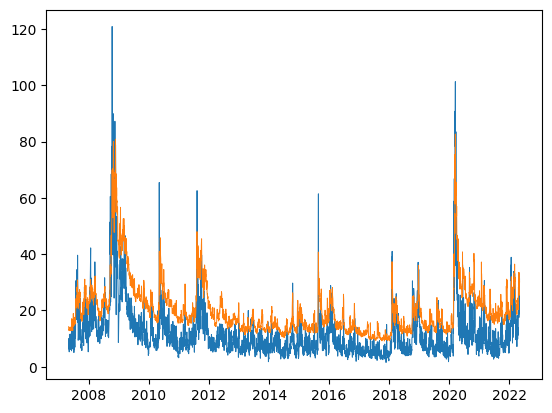

In [4]:
plt.plot(data["date"], data["rv"], linewidth=0.7)
plt.plot(data["date"], data["vix"], linewidth=0.7)

In [5]:
# Computing weekly RV
data = data.with_columns(
    pl.col("rv")
    .map(vol_annual_to_daily)
    .rolling_sum(5)
    .map(vol_weekly_to_annual)
    .alias("rv_weekly")
)

In [11]:
data = data.with_columns(
    (
        (pl.col("vix") - pl.col("vix").rolling_mean(21)) / pl.col("vix").rolling_std(21)
        >= 1.95
    ).alias("vix_jump")
)

data = data.with_columns(pl.col("vix").log().diff().alias("vix_change"))

data = data.with_columns(
    pl.col("vix_change").rolling_sum(5).shift(-5).alias("vix_change_5")
)
data = data.with_columns(
    pl.col("vix_change").rolling_sum(21).shift(-21).alias("vix_change_21")
)

data = data.drop_nulls()

In [ ]:
data.groupby("vix_jump").agg(pl.col("vix_change_5").mean())

vix_jump,vix_change_5
bool,f64
false,0.006497
true,-0.071037


In [ ]:
data.groupby("vix_jump").agg(pl.col("vix_change_21").mean())

vix_jump,vix_change_21
bool,f64
true,-0.13006
false,0.013534


In [25]:
vix = vix.with_columns(
    (
        (pl.col("vix") - pl.col("vix").rolling_mean(21)) / pl.col("vix").rolling_std(21)
        >= 1.95
    ).alias("vix_jump")
)

vix = vix.with_columns(
    pl.col("vix").log().diff().rolling_sum(21).shift(-21).alias("vix_forward_chg")
)

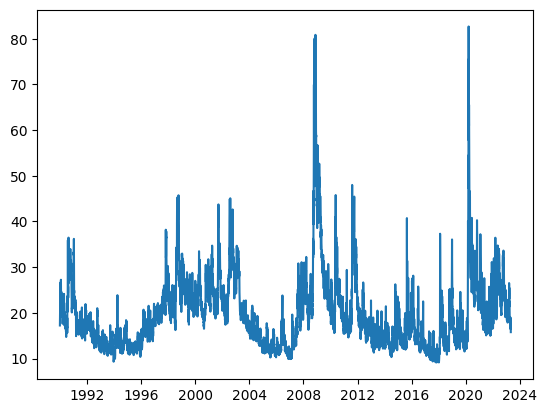

In [27]:
plt.plot(vix["date"], vix["vix"])

(array([1.760e+02, 6.880e+02, 1.029e+03, 8.030e+02, 8.220e+02, 7.190e+02,
        6.170e+02, 6.230e+02, 5.570e+02, 4.630e+02, 4.060e+02, 3.120e+02,
        2.380e+02, 1.900e+02, 1.540e+02, 1.290e+02, 9.900e+01, 5.100e+01,
        5.300e+01, 3.300e+01, 3.400e+01, 3.300e+01, 2.500e+01, 2.600e+01,
        2.300e+01, 1.200e+01, 5.000e+00, 6.000e+00, 4.000e+00, 5.000e+00,
        7.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 6.000e+00,
        2.000e+00, 5.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00]),
 array([ 9.14 , 10.611, 12.082, 13.553, 15.024, 16.495, 17.966, 19.437,
        20.908, 22.379, 23.85 , 25.321, 26.792, 28.263, 29.734, 31.205,
        32.676, 34.147, 35.618, 37.089, 38.56 , 40.031, 41.502, 42.973,
        44.444, 45.915, 47.386, 48.857, 50.328, 51.799, 53.27 , 54.741,
        56.212, 57.683, 59.154, 60.625, 62.096, 63.567, 65.038, 66.509,
        67.98 , 

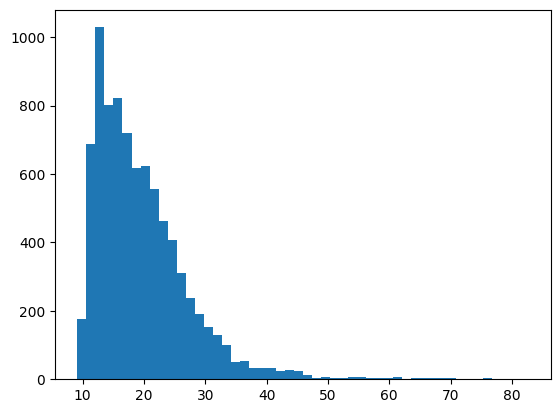

In [29]:
plt.hist(vix["vix"], bins=50)